# Gill-Matsuno model

The Gill-Matsuno model is a classical atmospheric model that describes the tropical atmospheric response to a prescribed heating. It consists of 3 prognostic variables $u$, $v$, and $p$ in an equatorial beta-plane approximation. The non-dimensional form of the equations is given by:

$$
\frac{\partial u}{\partial t} + eu - \frac{1}{2} yv = -\frac{\partial p}{\partial x}
$$
$$
\frac{\partial v}{\partial t} + ev + \frac{1}{2} yu = -\frac{\partial p}{\partial y}
$$
$$
\frac{\partial p}{\partial t} + ep + \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = -Q
$$

This cookbook aims to reproduce the results of the classical Gill-Matsuno model experiment in different forcing scenarios. The model is set up on a grid with prescribed parameters, and the forcing function $Q$ is defined to represent the heating in the atmosphere. Here we will explore the steady-state solution of the set of equations outline above, which is often used to analyze the tropical atmospheric dynamics in a simplified manner.

## Imports

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numba

## Discretization
The numerical scheme used to solve the equations is a forward-in-time, centered-in-space finite difference method.

In [43]:
@numba.njit
def damping(field, epsilon):
    """Calculates the damping for a given field."""
    return -epsilon * field

@numba.njit
def coriolis_term(field, yy, sign=1):
    """Calculates the Coriolis term"""
    return 0.5 * yy * field * sign

In [44]:
@numba.njit
def pressure_gradient_x(p, dx):
    """Calculates the pressure gradient in the x-direction."""
    term = np.zeros_like(p)
    for i in range(1, p.shape[0] - 1):
        for j in range(1, p.shape[1] - 1):
            term[i, j] = -(p[i + 1, j] - p[i - 1, j]) / (2 * dx)
    return term

@numba.njit
def pressure_gradient_y(p, dy):
    """Calculates the pressure gradient in the y-direction."""
    term = np.zeros_like(p)
    for i in range(1, p.shape[0] - 1):
        for j in range(1, p.shape[1] - 1):
            term[i, j] = -(p[i, j + 1] - p[i, j - 1]) / (2 * dy)
    return term

In [45]:
@numba.njit
def divergence(u, v, dx, dy):
    """Calculates the divergence for the pressure equation."""
    term = np.zeros_like(u)
    for i in range(1, u.shape[0] - 1):
        for j in range(1, u.shape[1] - 1):
            du_dx = (u[i + 1, j] - u[i - 1, j]) / (2 * dx)
            dv_dy = (v[i, j + 1] - v[i, j - 1]) / (2 * dy)
            term[i, j] = -(du_dx + dv_dy)
    return term

In [46]:
@numba.njit
def apply_boundary_conditions(u, v, p):
    """Applies periodic zonal and zero-gradient meridional boundary conditions."""
    u[0, :], u[-1, :] = u[-2, :], u[1, :]
    v[0, :], v[-1, :] = v[-2, :], v[1, :]
    p[0, :], p[-1, :] = p[-2, :], p[1, :]
    u[:, 0], u[:, -1] = u[:, 1], u[:, -2]
    v[:, 0], v[:, -1] = v[:, 1], v[:, -2]
    p[:, 0], p[:, -1] = p[:, 1], p[:, -2]
    return u, v, p

@numba.njit
def apply_boundary_conditions(u, v, p):
    """
    Applies periodic zonal and zero-gradient meridional boundary conditions
    to a 2D slice of the model state.
    """
    # Periodic in x (zonal)
    u[0, :], u[-1, :] = u[-2, :], u[1, :]
    v[0, :], v[-1, :] = v[-2, :], v[1, :]
    p[0, :], p[-1, :] = p[-2, :], p[1, :]

    # Zero-gradient in y (meridional)
    u[:, 0], u[:, -1] = u[:, 1], u[:, -2]
    v[:, 0], v[:, -1] = v[:, 1], v[:, -2]
    p[:, 0], p[:, -1] = p[:, 1], p[:, -2]

    return u, v, p

In [47]:
@numba.njit
def numba_solver_loop(u, v, p, Q, yy, params_tuple):
    """
    Performs the time-stepping, modifying the 3D u, v, p arrays in place.
    """
    # Unpack parameters
    dt, dx, dy, eps_u, eps_v, eps_p, num_steps = params_tuple

    # Time-stepping loop
    for n in range(num_steps - 1):
        # Get the current state (a 2D slice)
        u_n, v_n, p_n = u[n, :, :], v[n, :, :], p[n, :, :]

        # --- Calculate full tendency fields using the current state ---
        du_dt = damping(u_n, eps_u) + coriolis_term(v_n, yy, 1) + pressure_gradient_x(p_n, dx)
        dv_dt = damping(v_n, eps_v) + coriolis_term(u_n, yy, -1) + pressure_gradient_y(p_n, dy)
        dp_dt = damping(p_n, eps_p) + divergence(u_n, v_n, dx, dy) + Q

        # --- Update the NEXT time slice in the main arrays ---
        u[n + 1, :, :] = u_n + du_dt * dt
        v[n + 1, :, :] = v_n + dv_dt * dt
        p[n + 1, :, :] = p_n + dp_dt * dt

        # --- Apply Boundary Conditions ---
        u[n + 1, :, :], v[n + 1, :, :], p[n + 1, :, :] = apply_boundary_conditions(
            u[n + 1, :, :], v[n + 1, :, :], p[n + 1, :, :]
        )

In [48]:
def setup_and_run_model(params):
    """Sets up the grid and initial conditions, then runs the solver."""
    Lx, Ly, dx, dy = params['Lx'], params['Ly'], params['dx'], params['dy']
    num_steps = params['num_steps']

    xs, ys = np.arange(0, Lx + dx, dx), np.arange(-Ly, Ly + dy, dy)
    x_dim, y_dim = len(xs), len(ys)
    
    # --- Create 3D arrays with time as the first dimension ---
    u = np.zeros((num_steps, x_dim, y_dim))
    v = np.zeros_like(u)
    p = np.zeros_like(u)

    # Grid and forcing are 2D
    xx, yy = np.meshgrid(xs, ys, indexing='ij')
    Q = np.zeros_like(xx)
    L_forcing = 2.0
    heating_mask = (xx > 4 * L_forcing) & (xx < 6 * L_forcing)
    Q[heating_mask] = -(np.sin(np.pi / (2 * L_forcing) * xx[heating_mask]) *
                       np.exp(-0.25 * yy[heating_mask]**2))
    
    grid = {'xs': xs, 'ys': ys, 'xx': xx, 'yy': yy}

    # Pack parameters for Numba
    params_tuple = (params['dt'], dx, dy, params['eps_u'], params['eps_v'],
                    params['eps_p'], num_steps)

    print("🚀 Starting simulation...")
    start_time = time.time()
    
    # Run the solver (modifies u, v, p in place)
    numba_solver_loop(u, v, p, Q, yy, params_tuple)
    
    end_time = time.time()
    print(f"✅ Simulation finished in {end_time - start_time:.2f} seconds.")
    
    return u, v, p, Q, grid

In [ ]:
def plot_results(u, v, p, grid):
    """Visualizes the final steady-state solution."""
    xx, yy = grid['xx'], grid['yy']
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    contour = ax.contourf(xx.T, yy.T, p.T, levels=15, cmap='Blues_r')
    # fig.colorbar(contour, ax=ax, label='Pressure Anomaly (p)')
    ax.contour(xx.T, yy.T, p.T, levels=contour.levels, colors='k', linewidths=0.7)
    skip = (slice(None, None, 4), slice(None, None, 2))
    ax.quiver(xx[skip].T, yy[skip].T, u[skip].T, v[skip].T, color='black', scale=20)
    ax.set_title('Gill-Matsuno Model', fontsize=16)
    ax.set_xlabel('Zonal Distance (x)', fontsize=12)
    ax.set_ylabel('Meridional Distance (y)', fontsize=12)
    plt.show()

In [50]:
model_parameters = {
    'Lx': 25.0, 'Ly': 5.0,
    'dx': 0.5, 'dy': 0.5,
    'dt': 0.01,
    'eps_u': 0.1, 'eps_v': 0.1, 'eps_p': 0.1,
    'num_steps': 3000,
}

In [51]:
u, v, p, Q, grid = setup_and_run_model(model_parameters)

🚀 Starting simulation...
✅ Simulation finished in 1.41 seconds.


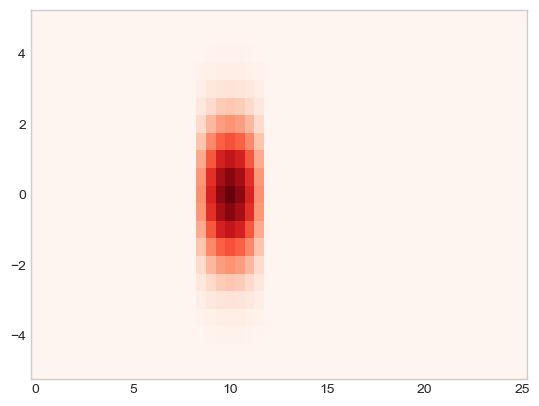

In [52]:
plt.pcolormesh(grid['xx'].T, grid['yy'].T, Q.T, cmap='Reds_r')

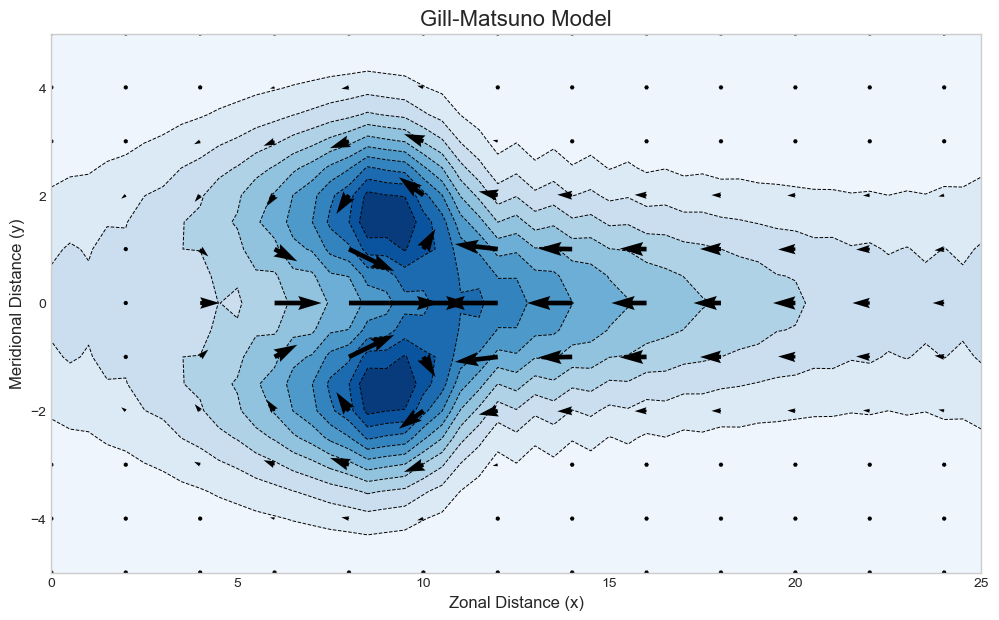

In [53]:
# Visualize the results
plot_results(u[-1], v[-1], p[-1], grid)